In [83]:
library(dplyr)
library(ggplot2)
library(susieR)
library(stringr)
library(data.table)
library(ggplot2)
library(ggrepel)

In [104]:
Region <- '1KGP_hg19_CEL_1MB.vcf.gz'
seed <- 4
n_CV <- 2
n_Ctrl <- 20000
n_Case <- 2000

# Get maf

In [88]:
vcf_maf <- read.table(paste0("simulation_summary_stats/",Region,"_snp_maf_0.05.tsv"),
           header=F, sep='\t')

dim(vcf_maf)
head(vcf_maf)

[1] 2665 2513

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V2504,V2505,V2506,V2507,V2508,V2509,V2510,V2511,V2512,V2513
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,9,135437285,rs7024404,A,G,100,PASS,AC=2304;AF=0.460064;AN=5008;NS=2504;DP=16408;EAS_AF=0.3978;AMR_AF=0.3501;AFR_AF=0.6694;EUR_AF=0.3996;SAS_AF=0.3814;AA=G|||;VT=SNP,GT,1|0,⋯,1|1,1|1,0|0,0|0,0|1,0|0,0|0,0|0,1|0,0|0
2,9,135437812,rs4962191,A,T,100,PASS,AC=1448;AF=0.289137;AN=5008;NS=2504;DP=18859;EAS_AF=0.3512;AMR_AF=0.245;AFR_AF=0.2738;EUR_AF=0.2962;SAS_AF=0.2699;AA=A|||;VT=SNP,GT,1|0,⋯,1|0,1|1,0|0,0|0,0|1,0|0,0|0,0|0,1|0,0|0
3,9,135438097,rs4962192,T,A,100,PASS,AC=1066;AF=0.212859;AN=5008;NS=2504;DP=17550;EAS_AF=0.3492;AMR_AF=0.2176;AFR_AF=0.0378;EUR_AF=0.2724;SAS_AF=0.2444;AA=T|||;VT=SNP,GT,1|0,⋯,1|0,1|1,0|0,0|0,0|1,0|0,0|0,0|0,1|0,0|0
4,9,135438468,rs60358479,A,C,100,PASS,AC=383;AF=0.0764776;AN=5008;NS=2504;DP=17272;EAS_AF=0.001;AMR_AF=0.0303;AFR_AF=0.2247;EUR_AF=0.0169;SAS_AF=0.0481;AA=A|||;VT=SNP,GT,0|0,⋯,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
5,9,135441627,rs17149294,A,G,100,PASS,AC=489;AF=0.0976438;AN=5008;NS=2504;DP=19189;EAS_AF=0.001;AMR_AF=0.0922;AFR_AF=0.2254;EUR_AF=0.1024;SAS_AF=0.0235;AA=A|||;VT=SNP,GT,0|0,⋯,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
6,9,135441661,rs17149298,C,T,100,PASS,AC=471;AF=0.0940495;AN=5008;NS=2504;DP=19373;EAS_AF=0.001;AMR_AF=0.0893;AFR_AF=0.2133;EUR_AF=0.1024;SAS_AF=0.0235;AA=C|||;VT=SNP,GT,0|0,⋯,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [89]:
vcf_maf_for_maf <- select(vcf_maf, rsid=V3, V8)
vcf_maf_for_maf$maf <- stringr::str_extract(vcf_maf_for_maf$V8, "AF=\\d+\\.\\d+")
vcf_maf_for_maf <- select(vcf_maf_for_maf, -V8)
vcf_maf_for_maf$maf <- as.numeric(stringr::str_replace(vcf_maf_for_maf$maf, "AF=",""))
vcf_maf_for_maf$maf[vcf_maf_for_maf$maf > 0.5] <- 1-(vcf_maf_for_maf$maf[vcf_maf_for_maf$maf > 0.5])

head(vcf_maf_for_maf)

,rsid,maf
,<chr>,<dbl>
1,rs7024404,0.4600640
2,rs4962191,0.2891370
3,rs4962192,0.2128590
4,rs60358479,0.0764776
5,rs17149294,0.0976438
6,rs17149298,0.0940495


# Load summary statistics

In [105]:
sum.stats <- read.table(paste0('simulation_summary_stats/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.tsv'), header=T)

dim(sum.stats)
head(sum.stats)

[1] 2665    6

,snps,z,p.value,log.p.value,CV,OR
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,rs7024404,-1.0410582,0.2978486,-1.2111701,0,1
2,rs4962191,-0.5416807,0.5880385,-0.5309629,0,1
3,rs4962192,-0.3180073,0.7504794,-0.2870431,0,1
4,rs60358479,-0.4685900,0.6393627,-0.4472834,0,1
5,rs17149294,-0.4358003,0.6629816,-0.4110080,0,1
6,rs17149298,-0.4353291,0.6633236,-0.4104924,0,1


In [106]:
sum.stats[which(sum.stats$CV !=0),]
vcf_maf_for_maf[which(sum.stats$CV !=0),]

,snps,z,p.value,log.p.value,CV,OR
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
587,rs809264,1.580919,0.11389647,-2.172465,2,1.144373
1528,rs11244037,2.137690,0.03254191,-3.425227,1,1.088903


,rsid,maf
,<chr>,<dbl>
587,rs809264,0.240815
1528,rs11244037,0.102636


In [107]:
sum(abs(sum.stats$log.p.value) == Inf, na.rm=T)
sum.stats[which(is.na(sum.stats$log.p.value)),]

[1] 0

snps,z,p.value,log.p.value,CV,OR
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>


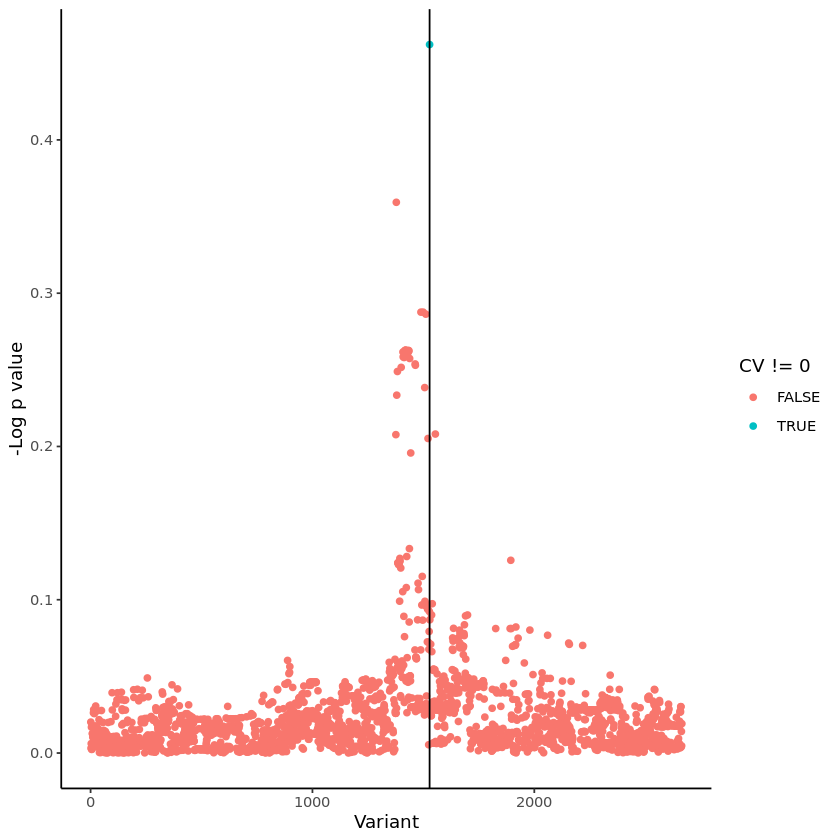

In [99]:
ggplot(sum.stats, aes(x=1:nrow(sum.stats),y=-log10(p.value), color=CV!=0)) + 
    geom_point() + 
    geom_vline(xintercept=which(sum.stats$CV !=0)) +
    theme_classic() +
    ylab('-Log p value') + xlab('Variant')

In [80]:
snps <- unlist(read.table(paste0('simulation_summary_stats/',Region,'_snp_maf_0.05.snp')))
r <- data.table::fread(paste0('1KGP_Regions/',Region,'.r.maf.order.ld'))
colnames(r) <- snps
rownames(r) <- snps
r <- as.matrix(r)

dim(r)
head(r)

[1] 3478 3478

rs218367,rs218369,rs177933,rs172637,rs218370,rs9984890,rs9984905,rs9981024,rs9985096,rs511247,⋯,rs56036790,rs4920006,rs6586259,rs7277472,rs78628864,rs2008193,rs1041452,rs9974287,rs2839600,rs2839601
1.000000,0.937913,0.653390,0.961824,0.652485,0.961762,0.961800,0.461720,0.455694,0.615886,⋯,-0.0302197,-0.0472993,0.1674840,0.1479020,-0.0711611,0.1115570,0.1102200,0.1674840,-0.0681848,0.166422
0.937913,1.000000,0.698584,0.941209,0.697750,0.941175,0.941214,0.453064,0.448987,0.663635,⋯,-0.0372124,-0.0523575,0.1915180,0.1764520,-0.0799860,0.1298050,0.1276180,0.1915180,-0.0737996,0.185836
0.653390,0.698584,1.000000,0.678650,0.997629,0.678831,0.679045,0.317778,0.313230,0.923210,⋯,0.0233622,-0.0126719,0.0890617,0.0772797,-0.0663219,0.0590416,0.0573795,0.0890617,-0.0181241,0.103084
0.961824,0.941209,0.678650,1.000000,0.677795,0.998042,0.998042,0.461074,0.455035,0.637564,⋯,-0.0303986,-0.0548102,0.1737670,0.1522800,-0.0704988,0.1156670,0.1144130,0.1737670,-0.0749208,0.171800
0.652485,0.697750,0.997629,0.677795,1.000000,0.677974,0.678190,0.317814,0.313261,0.922243,⋯,0.0230269,-0.0113578,0.0885185,0.0771606,-0.0668213,0.0590259,0.0565889,0.0885185,-0.0169044,0.102447
0.961762,0.941175,0.678831,0.998042,0.677974,1.000000,0.999019,0.462412,0.458167,0.638674,⋯,-0.0300495,-0.0529689,0.1748450,0.1528260,-0.0701798,0.1168490,0.1156030,0.1748450,-0.0731062,0.172999


In [81]:
sum(is.na(r))

[1] 0

# SuSiE

# FINEMAP

In [117]:
sum.stats.maf <- left_join(left_join(sum.stats, vcf_maf_for_maf, join_by(snps==rsid)),
                           select(vcf_maf, chr=V1, pos=V2, snps=V3, ref=V4, alt=V5))

sum(is.na(sum.stats.maf$maf))
dim(sum.stats.maf)
head(sum.stats.maf)

Joining with `by = join_by(snps)`


[1] 0

[1] 2665   11

,snps,z,p.value,log.p.value,CV,OR,maf,chr,pos,ref,alt
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
1,rs7024404,-1.0410582,0.2978486,-1.2111701,0,1,0.4600640,9,135437285,A,G
2,rs4962191,-0.5416807,0.5880385,-0.5309629,0,1,0.2891370,9,135437812,A,T
3,rs4962192,-0.3180073,0.7504794,-0.2870431,0,1,0.2128590,9,135438097,T,A
4,rs60358479,-0.4685900,0.6393627,-0.4472834,0,1,0.0764776,9,135438468,A,C
5,rs17149294,-0.4358003,0.6629816,-0.4110080,0,1,0.0976438,9,135441627,A,G
6,rs17149298,-0.4353291,0.6633236,-0.4104924,0,1,0.0940495,9,135441661,C,T


In [120]:
finemap.in <- select(sum.stats.maf, rsid=snps, chromosome=chr,
      position=pos, allele1=ref, allele2=alt, maf=maf, 
      beta=z)
finemap.in$se <- 1

write.table(finemap.in,
            paste0('simulation_summary_stats/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.z'),
            col.names=T, row.names=F, quote=F, sep=' ')

In [125]:
dir.create(paste0('finemapping_results/',Region,'_',seed), recursive=T)

finemap_master <- data.frame(z=paste0('simulation_summary_stats/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.z'),
           ld=paste0('1KGP_Regions/',Region,'.r.maf.order.ld'),
           snp=paste0('finemapping_results/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.snp'),
           config=paste0('finemapping_results/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.config'),
           cred=paste0('finemapping_results/',
                               Region,'_',seed,
                               '/finemapping_results',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.cred'),
           log=paste0('finemapping_results/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.log'),
           n_samples=(n_Ctrl + n_Case))
finemap_master

z,ld,snp,config,cred,log,n_samples
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
simulation_summary_stats/1KGP_hg19_CEL_1MB.vcf.gz_4/ss_2_CV_20000_ctrl_2000_case.finemap.z,1KGP_Regions/1KGP_hg19_CEL_1MB.vcf.gz.r.maf.order.ld,finemapping_results/1KGP_hg19_CEL_1MB.vcf.gz_4/ss_2_CV_20000_ctrl_2000_case.finemap.snp,finemapping_results/1KGP_hg19_CEL_1MB.vcf.gz_4/ss_2_CV_20000_ctrl_2000_case.finemap.config,finemapping_results/1KGP_hg19_CEL_1MB.vcf.gz_4/finemapping_results2_CV_20000_ctrl_2000_case.finemap.cred,simulation_summary_stats/1KGP_hg19_CEL_1MB.vcf.gz_4/ss_2_CV_20000_ctrl_2000_case.finemap.log,22000


In [126]:
write.table(finemap_master,paste0('finemapping_results/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.master'),
           quote=F, col.names=T, row.names=F, sep=';')

In [127]:
write.table(paste0('finemap --sss --in-files ', 'finemapping_results/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.master'),
           paste0('finemapping_results/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.sh'),
           quote=F, col.names=F, row.names=F)

# Infinitesimal Inputs

In [138]:
write.table(paste0('python ../tools/fine-mapping-inf/run_fine_mapping.py --sumstats ', 
                   'simulation_summary_stats/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.finemap.z',
                   ' --z-col-name beta --ld-file ',
                   '1KGP_Regions/',Region,'.r.maf.order.ld.gz'
                   ,' --n ', (n_Ctrl + n_Case),
                   ' --save-tsv --output-prefix ',
                   'finemapping_results/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.inf'
                   ,' > ', 'finemapping_results/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.inf.log'),
           paste0('finemapping_results/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.inf.sh'),
           quote=F, col.names=F, row.names=F)

# Run SuSiE

In [ ]:
sum.stats <- read.table(paste0('simulation_summary_stats/',
                               Region,'_',seed,
                               '/ss_',n_CV,'_CV_',n_Ctrl,'_ctrl_',n_Case,'_case.tsv'), header=T)

dim(sum.stats)
head(sum.stats)

In [ ]:
snps <- unlist(read.table(paste0('simulation_summary_stats/',Region,'_snp_maf_0.05.snp')))
r <- data.table::fread(paste0('1KGP_Regions/',Region,'.r.maf.order.ld'))
colnames(r) <- snps
rownames(r) <- snps
r <- as.matrix(r)

dim(r)
head(r)

In [82]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2232478,119.3,3940308,210.5,3940308,210.5
Vcells,31747659,242.3,834036640,6363.2,1085046904,8278.3


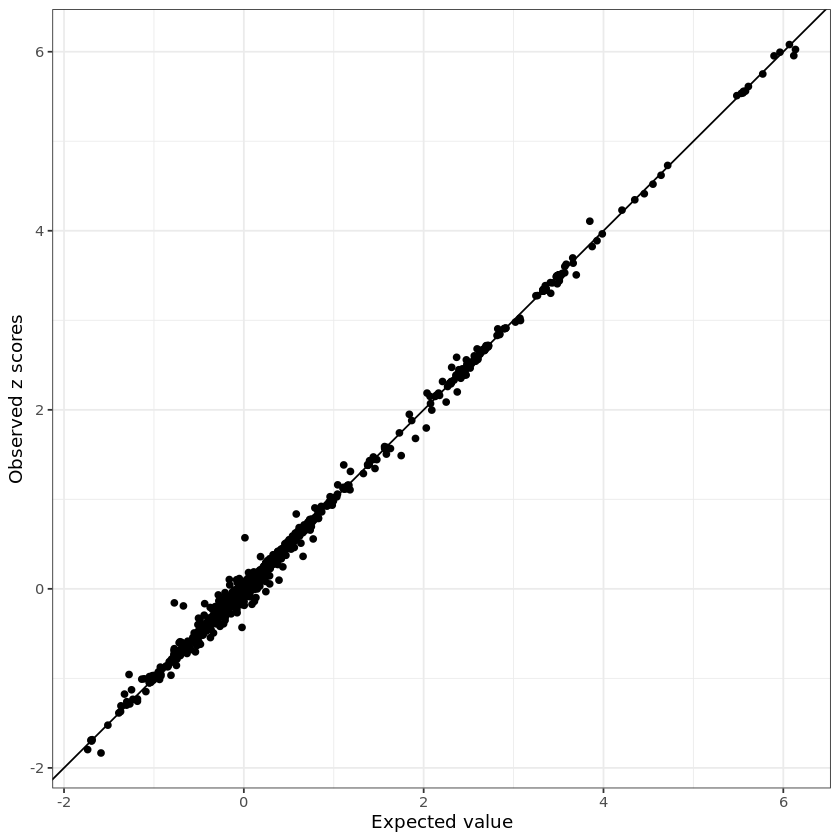

In [27]:
condz_in = kriging_rss(sum.stats$z, r, n=40000)
condz_in$plot

In [30]:
susie_results <- susie_rss(z=sum.stats$z, R=r_fix, n=40000)

HINT: For large R or large XtX, consider installing the Rfast package for better performance.




In [32]:
summary(susie_results)

,variable,variable_prob,cs
,<dbl>,<dbl>,<dbl>
1017,1017,2.664668e-01,1
1007,1007,1.930711e-01,1
1016,1016,1.613054e-01,1
1013,1013,1.287878e-01,1
1021,1021,1.272067e-01,1
1023,1023,4.024302e-02,1
1018,1018,1.862971e-02,1
1022,1022,1.408566e-02,1
1025,1025,1.390085e-02,1


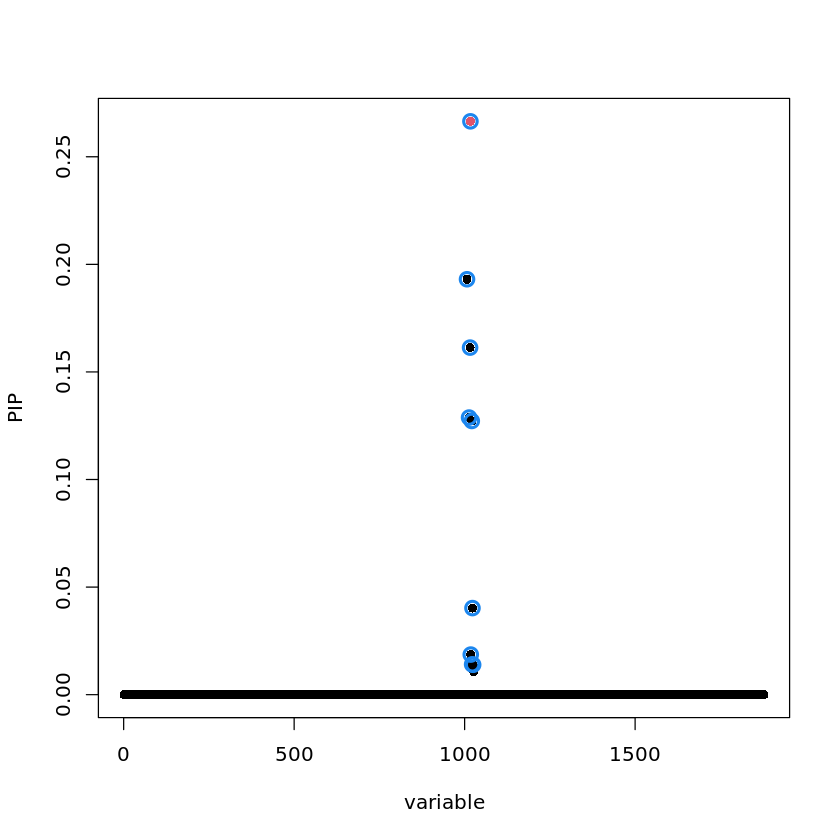

In [33]:
susie_plot(susie_results, y="PIP", b=(sum.stats$CV != 0))